In [1]:
import numpy as np
import os
import math
from os import path

import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

import glob
from aip import AipOcr

import json

import queue

In [2]:
completedVideo_fileName = 'subVideo/completed_video.avi'
sound_fileName = 'hdcctv1_0104.txt' 
#outfile = 'subTitle/hdcctv1_0102_subtitle.txt'

##  0. load in the completed video
vc = cv.VideoCapture(completedVideo_fileName)
vc_FPS = vc.get(cv.CAP_PROP_FPS)
vc_total = vc.get(cv.CAP_PROP_FRAME_COUNT)
#  success,frame = vc.read()


In [3]:
##  1.1 functions

def processPic(bgr_frame):
    #  将VideoCapture获得的frame进行颜色调整还有区域分割
    part = bgr_frame[400:,140:660,:]
    frame_rgb = cv.cvtColor(part,cv.COLOR_BGR2RGB)
    return frame_rgb
# def predictStt(rgb_part):
#     #  将rgb_part丢进来做成gray_part,并且判是否几乎全部大于240。即白色
#     gray_part = cv.cvtColor(rgb_part[100:135,5:11,:],cv.COLOR_RGB2GRAY)
#     return ((np.sum(gray_part < 240)/np.size(gray_part)) < 0.4)
    

In [4]:
##  1.2 构建单高斯背景建模函数
def SingleGaussianBGModel_initial(ini_frame):
    # formula
    # [cur_mean, cur_var, cur_sqrVar] = SingleGaussianBGModel_initial(ini_frame)
    ini_var = np.ones(np.shape(ini_frame),dtype=float)*20
    return [ini_frame, ini_var, ini_var*ini_var]

def SingleGaussianBGModel_process(lamda, alpha, cur_frame, last_mean, last_var, last_sqrVar):
    # formula
    # [cur_mean, cur_var, cur_sqrVar, determine]= SingleGaussianBGModel_process(lamda, alpha, cur_frame, last_mean, last_var, last_sqrVar)
    
    # determination for the BG/FG
    determine = np.zeros(np.shape(cur_frame))
    determine[np.abs(cur_frame-last_mean) < (lamda*last_var)] = 1  # BG = 1
    
    # update the 1>mean 2>var 3>sqrtVar
    cur_mean = (1-alpha)*last_mean + alpha*cur_frame
    cur_sqrVar = (1-alpha)*last_sqrVar + alpha*np.power((cur_frame-cur_mean),2)
    cur_var = np.sqrt(cur_sqrVar)
    
    return [cur_mean, cur_var, cur_sqrVar, determine]

def SingleGasussianBGModel_cur2last(cur_mean, cur_var, cur_sqrVar):
    # formula
    # [last_mean, last_var, last_sqrVar] = SingleGasussianBGModel_cur2last(cur_mean, cur_var, cur_sqrVar)
    return [cur_mean, cur_var, cur_sqrVar]

def SingleGaussianBGModel_BGextract(BGR, determine):
    import cv2
    [b,g,r] = cv2.split(BGR)
    return cv2.merge([r*determine, g*determine, b*determine])

In [5]:
##  2.1 分割出需要的BGFrame的绝对Index，存到subFrame中
#  语句分割后的json文件
soundFile = open(sound_fileName)  # 打开一个json文件
soundContext = json.load(soundFile)  # 传一个文件，读出内容转换成自定

#  将所有语句开始那一帧的时间提取出来
BtimeOriginTimeList = []  # 用毫秒表示的时间
BtimeFrameIndexList = []  # 各个Frame的绝对索引
for i in range(len(soundContext)):
    Btime = int(soundContext[i]['bg'])
    BtimeOriginTimeList.append(Btime)
    BtimeFrameIndexList.append(int(math.floor(Btime/1000)*vc_FPS+math.floor(Btime%1000/1000*vc_FPS)))
    
#print(BtimeFrameIndexList)
np.savetxt("subFrame/BGFrameIndex.txt", np.array(BtimeFrameIndexList))
np.savetxt("subFrame/BGFrameOrigin.txt",np.array(BtimeOriginTimeList))

In [6]:
#  2.2  将BG-frame存到subFrame中，将subtitle-part存在subTitle中
count = 0
BtimeSubtitleList = []  #各个frame中subtitle part的RGB

i = 0
while i < len(BtimeFrameIndexList):
    if count == BtimeFrameIndexList[i]:
        # 读取begin处的frame
        BtimeSuccess, BtimeFrame = vc.read()  
        # 存储这个frame到subFrame/x.jpg
        cv.imwrite('subFrame/'+str(count)+'.jpg',BtimeFrame)
        # 获取BG处subtitle的RGB信息
        BtimeSubtitleList.append(processPic(BtimeFrame)) 
        i += 1
        #print(count)
    else:
        vc.read()
    count +=1


In [7]:
##  3.1 预判是否为identical-subtitle
def predict_same(BtimeSubtitleList):
    BtimeIndenticalList = []
    BtimeIndenticalList.append(True)  # 第一个一定是独立的
    for i in range(len(BtimeSubtitleList)-1):
        firstGray = cv.cvtColor(BtimeSubtitleList[i][100:135,5:,:],cv.COLOR_RGB2GRAY)
        secondGray = cv.cvtColor(BtimeSubtitleList[i+1][100:135,5:,:],cv.COLOR_RGB2GRAY)
        diff = np.sum(np.power((firstGray - secondGray),2))/np.size(firstGray)
        if diff > 90:
            BtimeIndenticalList.append(True)  # 发生了变化就是独立的
        else:
            BtimeIndenticalList.append(False)  #没发生变化则不是独立的
        #print(BtimeFrameIndexList[i],BtimeIndenticalList[i])
    return BtimeIndenticalList

BGFrameIsSubtitle = predict_same(BtimeSubtitleList)  # True表示当前帧是发生了变化的
np.savetxt('subFrame/BGFrameIsSubtitle.txt',np.array(BGFrameIsSubtitle))

In [13]:
print(np.hstack((np.reshape(BtimeFrameIndexList,(np.size(BtimeFrameIndexList),1)),np.reshape(BGFrameIsSubtitle,(np.size(BGFrameIsSubtitle),1)))))


[[    0     1]
 [  386     1]
 [  670     1]
 [  871     0]
 [ 1171     0]
 [ 1292     0]
 [ 1478     0]
 [ 1595     0]
 [ 1840     0]
 [ 2019     0]
 [ 2210     0]
 [ 2492     1]
 [ 2843     0]
 [ 3103     1]
 [ 3455     0]
 [ 3574     1]
 [ 3726     1]
 [ 3808     1]
 [ 3939     1]
 [ 4036     1]
 [ 4095     1]
 [ 4187     1]
 [ 4514     1]
 [ 4565     1]
 [ 4605     1]
 [ 4735     1]
 [ 4877     1]
 [ 4917     1]
 [ 5225     1]
 [ 5535     1]
 [ 5863     1]
 [ 5949     0]
 [ 6137     0]
 [ 6329     1]
 [ 6379     0]
 [ 6433     0]
 [ 6495     1]
 [ 6531     0]
 [ 6558     1]
 [ 6609     0]
 [ 6652     0]
 [ 6765     1]
 [ 6789     0]
 [ 6999     1]
 [ 7207     1]
 [ 7277     1]
 [ 7370     1]
 [ 7421     1]
 [ 7534     1]
 [ 7820     1]
 [ 7856     1]
 [ 7906     1]
 [ 8007     1]
 [ 8117     1]
 [ 8284     1]
 [ 8452     1]
 [ 8546     1]
 [ 8575     0]
 [ 8674     1]
 [ 8699     1]
 [ 8732     1]
 [ 8924     1]
 [ 9030     1]
 [ 9187     1]
 [ 9555     1]
 [ 9630     1]
 [10026   

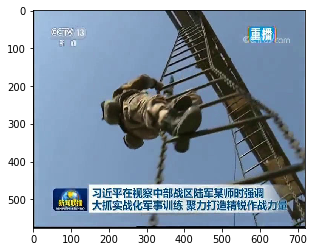

In [21]:
plt.imshow(plt.imread('subFrame/'+str(6137)+'.jpg'))

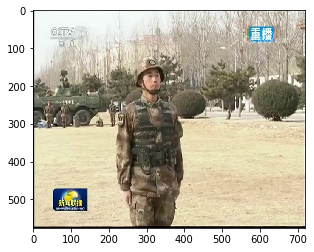

In [22]:
plt.imshow(plt.imread('subFrame/'+str(6329)+'.jpg'))

In [8]:
##  3.2 判断是否为字幕样式
# BtimeFrame_preStt_List = []
# for i in range(len(BtimeFrameList)):
#     if BtimeIndenticalList[i]:
#         BtimeFrame_preStt_List.append(predictStt(BtimeFrameList[i]))  # 是独立帧也得是预字幕帧
#     else:
#         BtimeFrame_preStt_List.append(False)  # 不是独立帧就不要了
        
#  最终筛选出来可以用于检测字幕的帧的索引
#subtitle_frameIndex = [i for i,x in enumerate(BtimeFrame_preStt_List) if x==True]
#print(subtitle_frameIndex)  
#ttt = BtimeFrameList[228]
#plt.imshow(ttt)
#plt.imshow(cv.cvtColor(ttt[100:135,5:,:],cv.COLOR_RGB2GRAY))
#print(cv.cvtColor(ttt[100:135,5:,:],cv.COLOR_RGB2GRAY))